In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deepthink.model import Model
from deepthink.layers import Conv2D, MaxPooling2D, Upsample2D
from deepthink.activations import ReLU, Sigmoid
from deepthink.optimizers import Adam
from deepthink.loss import MeanSquaredError
from deepthink.utils import load_mnist_data

## Autoencoder for Anomaly Detection

Anomaly detection is a crucial aspect of many fields, including cybersecurity, fraud detection, system health monitoring, and fault detection. In this context, we explore the use of autoencoders, a type of neural network, for detecting anomalies.

An autoencoder is a neural network that is trained to attempt to copy its input to its output. It consists of two main components: an encoder and a decoder. The encoder compresses the input into a lower-dimensional code, while the decoder reconstructs the input from this code. The goal of the autoencoder is to learn a compressed representation of the input data and to minimize the reconstruction error, which is the difference between the input and the output.

Autoencoders can be used for anomaly detection by training the network on normal data and then using it to detect anomalies in new data. The underlying idea is that the autoencoder will be able to reconstruct normal data with low error, but will have high error when trying to reconstruct anomalous data.

In this example, we use a simple autoencoder to detect anomalies in a subset of the MNIST dataset. The main steps in this example are:

1. Load the MNIST dataset
2. Train the autoencoder on normal data
3. Use the trained autoencoder to reconstruct new data and calculate the reconstruction error
4. Set a threshold for the reconstruction error to detect anomalies

In [2]:
# Define the hyperparameters
batch_size = 128
no_epochs = 3
no_classes = 10
validation_split = 0.2
learning_rate = 0.001
weight_init = 'he_uniform'
img_size = 28
input_shape = (batch_size, 1, img_size, img_size)

# Set the default pyplot style
plt.style.use('dark_background')

In [3]:

def get_stratified_subset(x_data, y_data, n_samples, n_classes=10):
    """Return a stratified subset of the data, stratified by class."""
    X_subset = np.zeros((n_samples * n_classes, *x_data.shape[1:]))
    y_subset = np.zeros((n_samples * n_classes, n_classes))
    for i in range(n_classes):
        idx = np.where(y_data.argmax(axis=1) == i)[0]
        np.random.shuffle(idx)
        X_subset[i * n_samples:(i + 1) * n_samples] = x_data[idx[:n_samples]]
        y_subset[i * n_samples:(i + 1) * n_samples] = y_data[idx[:n_samples]]
    
    return X_subset, y_subset


In [4]:
# Load MNIST dataset
path = '../Data/mnist784.p'
training_data, test_data = load_mnist_data(path)

# Unpack then split the data into training and validation sets
X_train_full, y_train_full = training_data
X_train, y_train = X_train_full[:50000], y_train_full[:50000]
X_val, y_val = X_train_full[50000:], y_train_full[50000:]
X_test, y_test = test_data

# Create stratified subset of training data
X_train, y_train = get_stratified_subset(X_train, y_train, 1000)
X_val, y_val = get_stratified_subset(X_val, y_val, 250)
X_test, y_test = get_stratified_subset(X_test, y_test, 250)

In [5]:
# Show data dimensions
print('Training data & labels: ', X_train.shape, y_train.shape)
print('Validation data & labels: ', X_val.shape, y_val.shape)
print('Testing data & labels: ', X_test.shape, y_test.shape)

Training data & labels:  (10000, 1, 28, 28) (10000, 10)
Validation data & labels:  (2500, 1, 28, 28) (2500, 10)
Testing data & labels:  (2500, 1, 28, 28) (2500, 10)


In [6]:
# Creating the model
opt = Adam(learning_rate)
model = Model(
    opt,
    cost=MeanSquaredError(),
    batch_size=batch_size
)
# Encoder
model.add_layer(Conv2D(
    kernel_size=3,
    n_filters=8,
    padding_type='same',
    stride=1,
    weight_init=weight_init,
    input_shape=input_shape)
)
model.add_layer(ReLU())
model.add_layer(MaxPooling2D())

# Decoder
model.add_layer(Conv2D(
    kernel_size=3,
    n_filters=8,
    padding_type='same',
    stride=1,
    weight_init=weight_init))
model.add_layer(ReLU())
model.add_layer(Upsample2D())
model.add_layer(Conv2D(
    kernel_size=3,
    n_filters=1,
    padding_type='same',
    stride=1,
    weight_init=weight_init))
model.add_layer(Sigmoid())

model.initialize()

model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Conv2D                    (None, 8, 28, 28)                    80
ReLU                      (None, 8, 28, 28)                     0
MaxPooling2D              (None, 8, 14, 14)                     0
Conv2D                    (None, 8, 14, 14)                   584
ReLU                      (None, 8, 14, 14)                     0
Upsample2D                (None, 8, 28, 28)                     0
Conv2D                    (None, 1, 28, 28)                    73
Sigmoid                   (None, 1, 28, 28)                     0
Total params: 737


In [7]:
# Get some sample images (one per class) that we will use for plotting
sample_images, sample_labels = get_stratified_subset(X_val, y_val, 1)


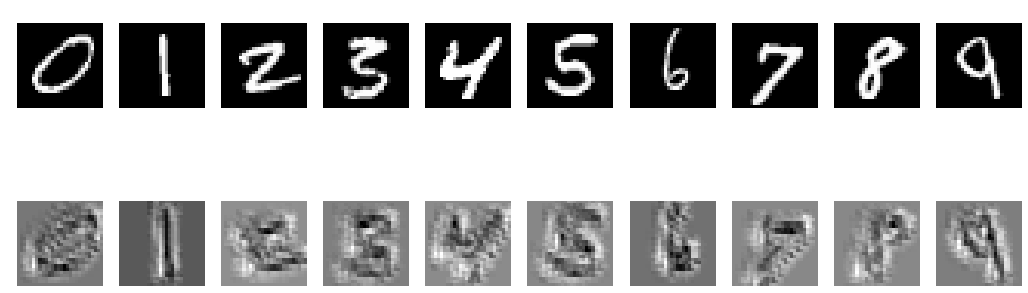

In [8]:
# Show predicted images before training the model
predictions = model.get_predictions(sample_images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(18, 6))

for i in range(10):
    axes[0][i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow(predictions[i].squeeze(), cmap='gray')
    axes[1][i].axis('off')

axes[0][0].set_title('Actual Images')
axes[1][0].set_title('Predicted Images')

plt.show()

#### Training the Autoencoder

The training process of an autoencoder differs slightly from that of a typical supervised learning model. Instead of predicting a target value, the autoencoder aims to minimize the reconstruction error, which is the difference between the input and the output (i.e., the decoded data). Therefore, when training the model, we use the same data for both the input and the target. The specific loss function used in this case is the mean squared error, which is suitable for this task as it measures the average squared difference between the actual and the predicted values.

To train our autoencoder we use the loop below, instead of the usual `model.train()` method. This is allows use to save the model's predictions for each epoch, which we can use to monitor the training progress.


In [9]:
loss_arr = []
val_loss_arr = []
model_preds = []
for epoch in range(no_epochs):
    model.train((X_train, X_train),
                validation_data=(X_val, X_val),
                epochs=1, verbose=True)
    
    loss_arr.append(model.history.history['loss'][0])
    val_loss_arr.append(model.history.history['val_loss'][0])

    # Get predictions for sample images after training
    predictions = model.get_predictions(sample_images)
    model_preds.append(predictions.squeeze(axis=1))

  0%|          | 0/78 [00:00<?, ?it/s]

100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Epoch: 1/1, elapsed-time: 0:00:21 - loss: 0.1643 - val_loss: 0.0648 - 


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Epoch: 1/1, elapsed-time: 0:00:21 - loss: 0.0275 - val_loss: 0.0143 - 


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Epoch: 1/1, elapsed-time: 0:00:21 - loss: 0.0114 - val_loss: 0.0093 - 


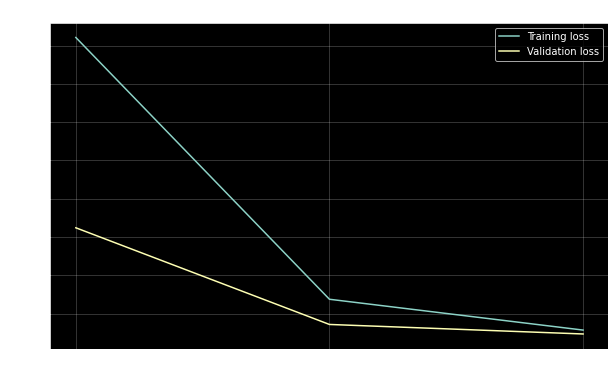

In [10]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(loss_arr, label='Training loss')
plt.plot(val_loss_arr, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True, alpha=0.25)
plt.title('Training and Validation Loss')
plt.xticks(range(0, no_epochs))
plt.legend()
plt.show()

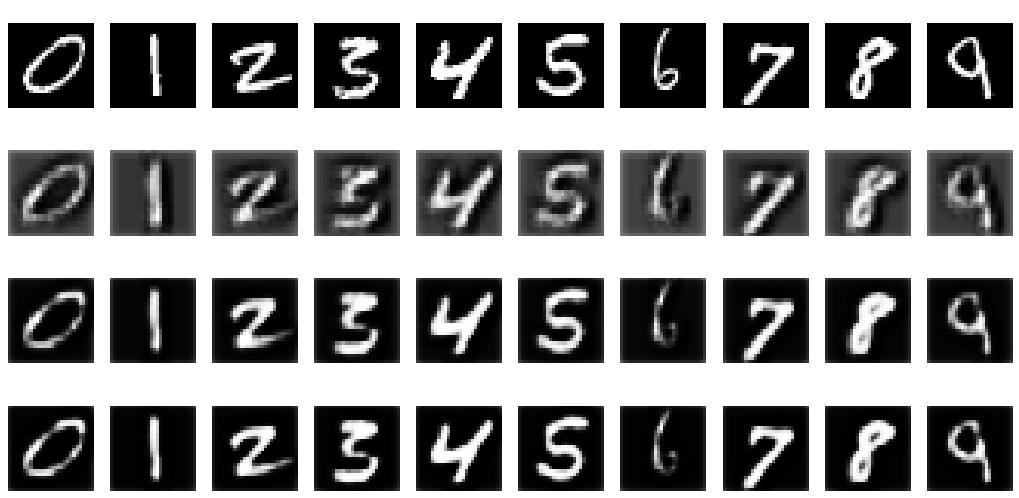

In [11]:
# Plot the sample images and their reconstructions
n_rows = no_epochs + 1
fig, axes = plt.subplots(nrows=n_rows, ncols=10, figsize=(18, 9))

axes[0][0].set_title('Actual Images')
for i in range(10):
    axes[0][i].imshow(sample_images[i].reshape(28, 28), cmap='gray')
    axes[0][i].axis('off')

for row in range(1, n_rows):
    axes[row][0].set_title(f'Epoch {row}')
    for col in range(10):
        axes[row][col].imshow(model_preds[row - 1][col], cmap='gray')
        axes[row][col].axis('off')

plt.show()

#### Using the Autoencoder for Anomaly Detection

Once the autoencoder is trained, we can use it to detect anomalies in new data. The idea is that the autoencoder will be able to reconstruct normal data with low error, but will have high error when trying to reconstruct anomalous data.

We first plot histograms of the mean absolute error on the training and validation data, to get a sense of the distribution of the errors. The distribution has a positive skew, indicating that the majority of the data has low error, but there are some outliers with high error.

We then set the reconstruction threshold, using the validation set. The threshold is set to be three standard deviations above the mean error on the validation set. This means that 99.7% of the validation data will be below the threshold, and anything above the threshold will be considered an anomaly.

Finally, we use the threshold to detect anomalies in the test set. The autoencoder successfully detects the anomalies in the test set, with the reconstruction error being higher for the anomalous data.

In [12]:
# Get train MAE loss
x_train_preds = model.get_predictions(X_train)
train_mae_loss = np.mean(np.abs(x_train_preds - X_train[:x_train_preds.shape[0]]), axis=(1, 2, 3))

# Get validation MAE loss
x_val_preds = model.get_predictions(X_val)
val_mae_loss = np.mean(np.abs(x_val_preds - X_val[:x_val_preds.shape[0]]), axis=(1, 2, 3))

print(f'MAE train loss mean: {train_mae_loss.mean():.4f}')
print(f'MAE train loss std: {train_mae_loss.std():.4f}')
print(f'\nMAE val loss mean: {val_mae_loss.mean():.4f}')
print(f'MAE val loss std: {val_mae_loss.std():.4f}')

MAE train loss mean: 0.0463
MAE train loss std: 0.0083

MAE val loss mean: 0.0463
MAE val loss std: 0.0084


In [13]:
# Choose a threshold value that is 3 standard deviations above the mean
threshold = np.mean(val_mae_loss) + 3 * np.std(val_mae_loss)
print(f'Error threshold using 3 std deviations: {threshold:.4f}')

Error threshold using 3 std deviations: 0.0713


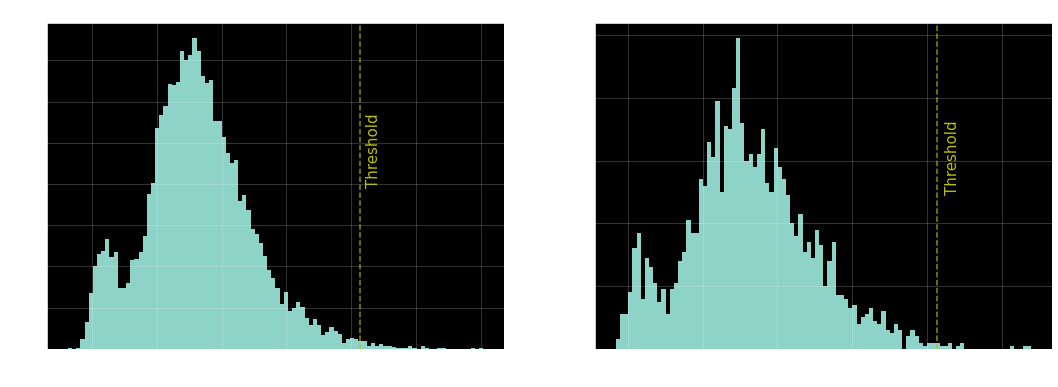

In [14]:
# Show the distribution of MAE losses
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].hist(train_mae_loss, bins=100)
axes[0].set_title('Train MAE Loss')
axes[0].set_xlabel('Train MAE loss')
axes[0].set_ylabel('No of samples')
axes[0].grid(True, alpha=0.25)
axes[0].axvline(threshold, color='y', linestyle='--', alpha=0.75)
axes[0].text(threshold + 0.001, 200, 'Threshold',
             fontsize=15, color='y', rotation=90)

axes[1].hist(val_mae_loss, bins=100)
axes[1].set_title('Validation MAE Loss')
axes[1].set_xlabel('Validation MAE loss')
axes[1].set_ylabel('No of samples')
axes[1].axvline(threshold, color='y', linestyle='--', alpha=0.75)
axes[1].text(threshold + 0.001, 50, 'Threshold',
             fontsize=15, color='y', rotation=90)
axes[1].grid(True, alpha=0.25)

plt.show()

In [15]:
# Get test preds
x_test_preds = model.get_predictions(X_test)
test_mae_loss = np.mean(np.abs(x_test_preds - X_test[:x_test_preds.shape[0]]), axis=(1, 2, 3))

print(f'MAE test loss mean: {test_mae_loss.mean():.4f}')
print(f'MAE test loss std: {test_mae_loss.std():.4f}')

MAE test loss mean: 0.0456
MAE test loss std: 0.0079


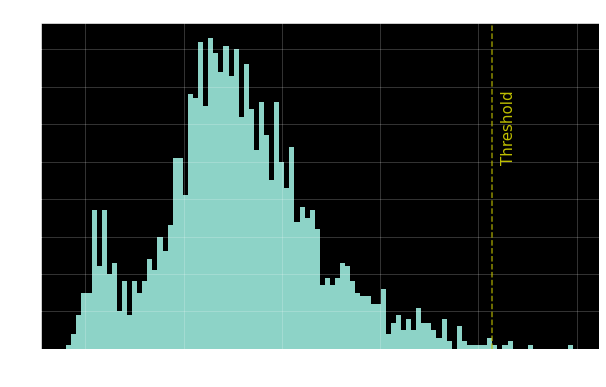

In [17]:
# Plot the test MAE loss
plt.figure(figsize=(10, 6))
plt.hist(test_mae_loss, bins=100)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.grid(True, alpha=0.25)
plt.title("Histogram of test MAE loss")
plt.axvline(threshold, color='y', linestyle='--', alpha=0.75)
plt.text(threshold + 0.001, 50, 'Threshold',
         fontsize=15, color='y', rotation=90)
plt.show()

In [18]:
outliers = np.where(test_mae_loss > threshold)[0]
print(f'Total test samples: {len(test_mae_loss)}')
print(f'Number of outliers: {len(outliers)}, ({len(outliers) / len(test_mae_loss):.2%})')

Total test samples: 2432
Number of outliers: 6, (0.25%)


In [19]:
# Show the outliers value counts
values, counts = np.unique(y_test[outliers].argmax(axis=1),
                            return_counts=True)
for value, count in zip(values, counts):
    print(f'Label {value}: {count}')

Label 5: 1
Label 6: 3
Label 8: 2


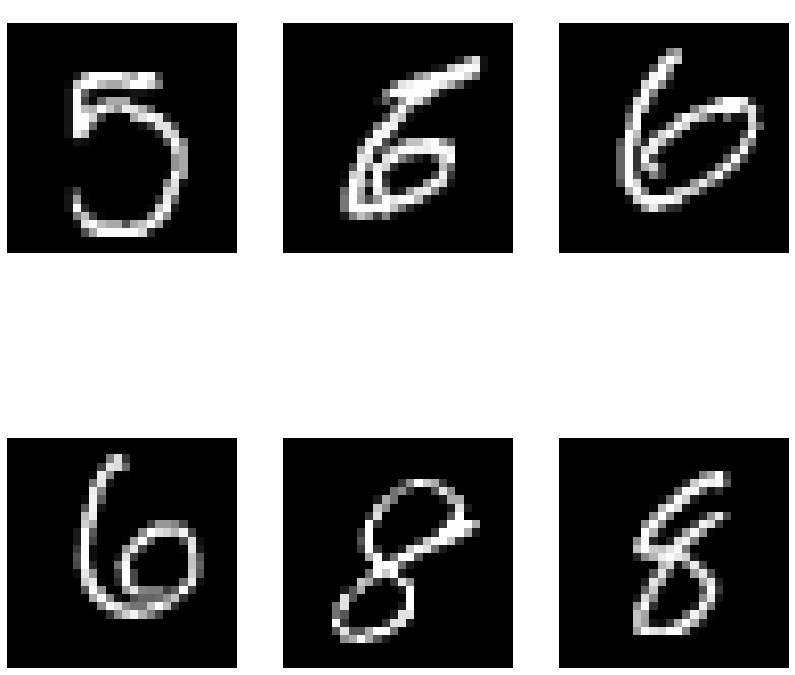

In [20]:
# Plot the outliers and their labels
fig, axes = plt.subplots(2, 3, figsize=(14, 14))

for ax, index in zip(axes.flatten(), outliers):
    ax.imshow(X_test[index].reshape(img_size, img_size),
              cmap='gray')
    ax.set_title(f'Label: {y_test[index].argmax()}')
    ax.axis('off')
plt.show()